In [16]:
# import statements
import pandas as pd
import numpy as np
import cv2
from sklearn import mixture
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pickle
import os

In [17]:
# Generic Functions used throughout the assignment

'''
Function that allows to create a single plot

:param img: matrix containing image and color channels
:param title: title of plot
:param grayscale: boolean for grayscale image (defaulted to true)
:param single: boolean for single image (defaulted to true)
'''
def generateSinglePlot(img, title, grayscale=True, single=True):
    if single:
        plt.rcParams['figure.figsize'] = [5, 5]
    if grayscale:
        plt.imshow(img, cmap='gray') # show grayscale image
    else:
        plt.imshow(img)
    plt.title(title)
    plt.xticks([]), plt.yticks([]) # remove axes ticks
    if single:
        plt.show()
    
# Subplot creation functions
subplots = [] # stores list of subplots that indicate number rows, cols and current plot

'''
Adds a subplot type to subplots lis"

:param rows: number of rows
:param cols: number of cols
:return index in subplots of where it was added (subplot id)
'''
def createSubPlot(rows=1, cols=3):
    subplots.append([rows, cols, 0])
    return len(subplots) - 1

'''
Adds a subplot to the specific id

:param id: index of subplot in subplots list
:param img: matrix containing image and color channels
:param title: title of plot
:param grayscale: boolean for grayscale image (defaulted to true)
'''
def addSubPlot(id, img, title, grayscale=True):
    val = subplots[id]
    val[2] += 1
    plt.subplot(val[0], val[1], val[2])
    generateSinglePlot(img, title, grayscale, single=False)
    if val[2] == val[0] * val[1]:
        del subplots[id]
        plt.show()
    

In [18]:
# obtain initial directory for images folder
directory = os.path.dirname(os.getcwd())+"\\face-detection\\images\\"

In [19]:
# helper functions and classes

#### LABELS ####
class Label:
    AKSHAY = 0
    ANGELA = 1
    ISAAC = 2
    MARK = 3
    NABILAH = 4
    ALL_PERSONS = 5

#### DATASET ####
class DataType:
    TRAIN = 0
    TEST = 1
    ALL_TYPE = 2

#### ANGLES ####
class Angle:
    DEG_0 = 0
    DEG_30 = 1
    DEG_45 = 2
    ALL_DEGREES = 3

#### ORIENTATIONS ####
class Orientation:
    CENTER = 0
    LEFT = 1
    RIGHT = 2
    ALL_ORIENTATIONS = 3

#### COLOR ####
class Color:
    RGB = 0
    GRAYSCALE = 1
    
class Scale:
    SMALL = 0
    MEDIUM = 1
    LARGE = 2
    ALL_SCALES = 3
    
def person_from_label(label):
    if label == Label.AKSHAY:
        return "Akshay"
    if label == Label.ANGELA:
        return "Angela"
    if label == Label.ISAAC:
        return "Isaac"
    if label == Label.MARK:
        return "Mark"
    if label == Label.NABILAH:
        return "Nabilah"
    return ""

def type_from_filename(filename):
    if filename.find("test") != -1:
        return DataType.TEST
    if filename.find("train") != -1:
        return DataType.TRAIN
    return -1

def person_from_filename(filename):
    if filename.find("akshay") != -1:
        return Label.AKSHAY
    if filename.find("angela") != -1:
        return Label.ANGELA
    if filename.find("mark") != -1:
        return Label.MARK
    if filename.find("isaac") != -1:
        return Label.ISAAC
    if filename.find("nabilah") != -1:
        return Label.NABILAH
    return -1

def degrees_from_filename(filename):
    if filename.find("_0_") != -1:
        return Angle.DEG_0
    if filename.find("_30") != -1:
        return Angle.DEG_30
    if filename.find("_45") != -1:
        return Angle.DEG_45
    return -1

def orientation_from_filename(filename):
    if filename.find("l_") != -1:
        return Orientation.LEFT
    if filename.find("r_") != -1:
        return Orientation.RIGHT
    return Orientation.CENTER

def scale_from_filename(filename):
    if filename.find("_1.") != -1:
        return Scale.SMALL
    if filename.find("_2.") != -1:
        return Scale.MEDIUM
    if filename.find("_3.") != -1:
        return Scale.LARGE
    return Scale.ALL_SCALES

def filter_data_df(data, i_type=DataType.ALL_TYPE, i_person=Label.ALL_PERSONS, i_degrees=Angle.ALL_DEGREES, i_orientation=Orientation.ALL_ORIENTATIONS, i_scale=Scale.ALL_SCALES):
    current_df = data

    if i_type != DataType.ALL_TYPE:
        current_df = current_df.loc[current_df['Type'] == i_type]
    if i_person != Label.ALL_PERSONS:
        current_df = current_df.loc[current_df['Person'] == i_person]
    if i_degrees != Angle.ALL_DEGREES:
        current_df = current_df.loc[current_df['Degree'] == i_degrees]
    if i_orientation != Orientation.ALL_ORIENTATIONS:
        current_df = current_df.loc[current_df['Orientation'] == i_orientation]
    if i_scale != Scale.ALL_SCALES:
        current_df = current_df.loc[current_df['Scale'] == i_scale]
    
    return current_df

In [20]:
# functions to create image dataframe if it is not already saved on the drive
def obtain_metadata_df():
    metadata_directory = directory + "metadata2.csv"
    # total number of rows
    total_rows = 145
    # obtain all bounding boxes
    metadata = pd.read_csv(metadata_directory, nrows=total_rows)
    # rename bounding box columns
    metadata.columns = ['Filename', 'TopLeftX', 'TopLeftY', 'BottomRightX', 'BottomRightY']
  
    return metadata

# check whether a point is inside a bounding box
def point_within_bounds(x, y, topleft_x, topleft_y, bottomright_x, bottomright_y):
    if x < topleft_x or x > bottomright_x:
        return False
    if y < topleft_y or y > bottomright_y:
        return False
    return True

# find all valid keypoints restricted in the face area for image 
def process_keypoints_image(raw_keypoints, topleft_x, topleft_y, bottomright_x, bottomright_y):
    keypoints = []
    for i in range(0, len(raw_keypoints)):
        if point_within_bounds(*raw_keypoints[i].pt, topleft_x, topleft_y, bottomright_x, bottomright_y):
            keypoints.append(raw_keypoints[i])
    return np.array(keypoints)

def process_harris_keypoints_image(raw_keypoints, topleft_x, topleft_y, bottomright_x, bottomright_y):
    keypoints = []
    for kp in raw_keypoints:
        if point_within_bounds(kp[0], kp[1], topleft_x, topleft_y, bottomright_x, bottomright_y):
            keypoints.append(kp)
    return np.array(keypoints)

# obtain sift features
def extract_sift_features(images):
    sift = cv2.xfeatures2d.SIFT_create(sigma=2.0, contrastThreshold=0.06)
    raw_keypoints = [sift.detect(image, None) for image in images]
    return np.array(raw_keypoints)

def extract_harris_features(images):
    feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.01,
                       minDistance = 8,
                       blockSize = 15,
                     useHarrisDetector=1)
    raw_keypoints = [cv2.goodFeaturesToTrack(image, **feature_params) for image in images]
    return np.array(raw_keypoints)

def create_data_df_from_metadata(metadata):
    IMAGE_COMPRESSION_SIZE = 256
    image_extension = ".jpg"
    all_rows = []
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    for k, row in metadata.iterrows():
        image_dict = row.to_dict()

        filename = row["Filename"]
        full_filename = directory + row["Filename"] + image_extension
        image_dict['Type'] = type_from_filename(filename)
        image_dict['Person'] = person_from_filename(filename)
        image_dict['Degree'] = degrees_from_filename(filename)
        image_dict['Orientation'] = orientation_from_filename(filename)
        image_dict['Scale'] = scale_from_filename(full_filename)

        image = cv2.imread(full_filename)
        image = cv2.resize(image, (IMAGE_COMPRESSION_SIZE, IMAGE_COMPRESSION_SIZE))
        image_dict['RGB'] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_dict['Grayscale'] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        all_rows.append(image_dict)
    
    # create dataframe of images
    images = pd.DataFrame(all_rows, columns=('Filename', 'TopLeftX', 'TopLeftY', 'BottomRightX', 'BottomRightY', 'Type', 'Person', 'Degree', 'Orientation', 'Scale', 'Grayscale', 'RGB'))

    return images

In [21]:
# obtain data from file or build df
data_directory = directory + "data.pkl"
if os.path.exists(data_directory):
    # if data is already pickled, load it back into df (faster)
    data = df = pd.read_pickle(data_directory)
else:
    metadata = obtain_metadata_df()
    data = create_data_df_from_metadata(metadata)
    data.to_pickle(data_directory)

In [22]:
gp_directory = directory + "group_photos\\"
all_files = os.listdir(gp_directory)

gp_rgb = []
gp_grayscale = []
for filename in all_files:
    full_filename = os.path.join(gp_directory, filename)
    image = cv2.imread(full_filename)
    image = cv2.resize(image,None,fx=0.25,fy=0.25)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gp_rgb.append(image_rgb)
    gp_grayscale.append(image_gray)

In [23]:
face_cascade = cv2.CascadeClassifier(directory + 'haarcascade_frontalface_alt.xml')

In [24]:
all_rois = []
detected = []
for color, gray in zip(gp_rgb, gp_grayscale):
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    image_cp = color.copy()
    rois = []
    for (x,y,w,h) in faces:
        image_cp = cv2.rectangle(image_cp,(x,y),(x+w,y+h),(255,0,0),3)
        roi_gray = gray[y:y+h, x:x+w]
        all_rois.append(roi_gray)
    detected.append(image_cp)


#### Mean Images and Principal Components

In [25]:
train_images = filter_data_df(data, i_type=DataType.TRAIN)
test_images = filter_data_df(data, i_type=DataType.TEST)

person = train_images['Person']
person_test = test_images['Person']

mat = []
for i in range(75):
    flat = train_images["Grayscale"][i].flatten()
    mat.append(flat)
train = np.array(mat)

In [26]:
mat = []
for i in range(75,145):
    flat = test_images["Grayscale"][i].flatten()
    mat.append(flat)
test = np.array(mat)

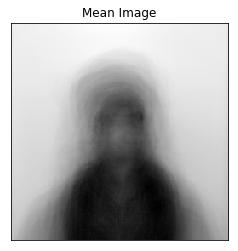

In [27]:
mean, eigvec = cv2.PCACompute(train, mean=None)
row,col = 256,256
avg = mean.reshape(row,col)

plt.imshow(avg, cmap = "gray")
plt.title("Mean Image"), plt.xticks([]), plt.yticks([])
plt.savefig('mean_image.png')
plt.show()

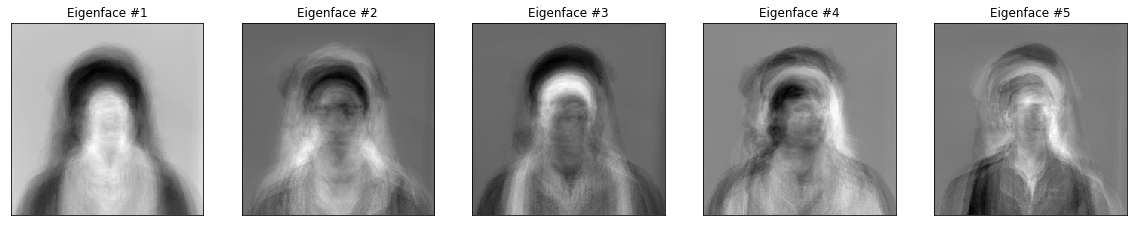

In [28]:
plt.figure(figsize=(20,5)) #Printing the first 5 eigenfaces
for i in range(5):
    plt.subplot(1,5,i+1), plt.title('Eigenface #{}'.format(i+1))
    plt.imshow(eigvec[i].reshape(row,col), cmap='gray'), plt.xticks([]), plt.yticks([])
plt.savefig('five_eigenfaces.png')
plt.show()

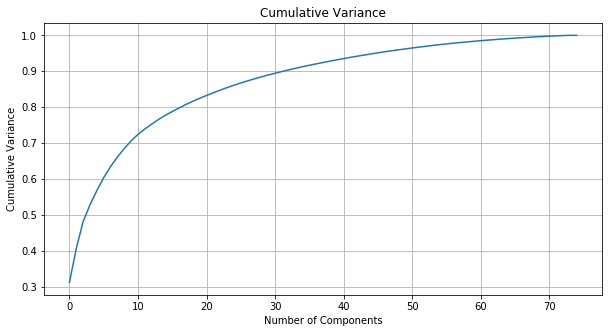

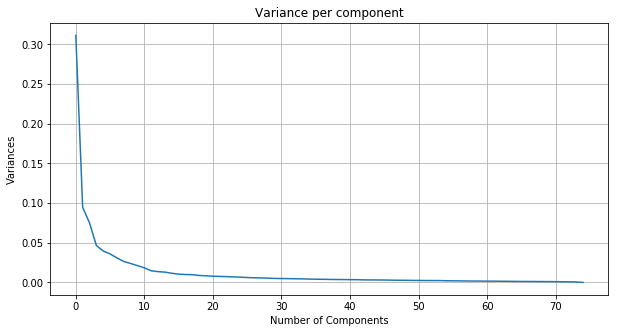

In [29]:
pca = PCA()
eg = pca.fit(train)
variances = eg.explained_variance_ratio_
cumvar = np.cumsum(variances)

# Plotting the cumulative variance to see how many PCAs contain most of the information
plt.figure(figsize=(10,5))  
plt.plot(cumvar)
plt.xlabel('Number of Components'),plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance'),plt.grid(True)
plt.savefig('cumvariance_plot.png')
plt.show()

# Plotting the variance of each principal compoenent to better visualize the information they contain
plt.figure(figsize=(10,5))
plt.plot(variances)
plt.xlabel('Number of Components'),plt.ylabel('Variances')
plt.title('Variance per component'),plt.grid(True)
plt.savefig('variance_plot.png')
plt.show()

One can see from the graphs above that using approximately 15 principal components should be enough

In [30]:
pca2 = PCA(n_components=15).fit(train)
train_pca = pca2.transform(train)
projections = pca2.inverse_transform(train_pca) #This works as the projection

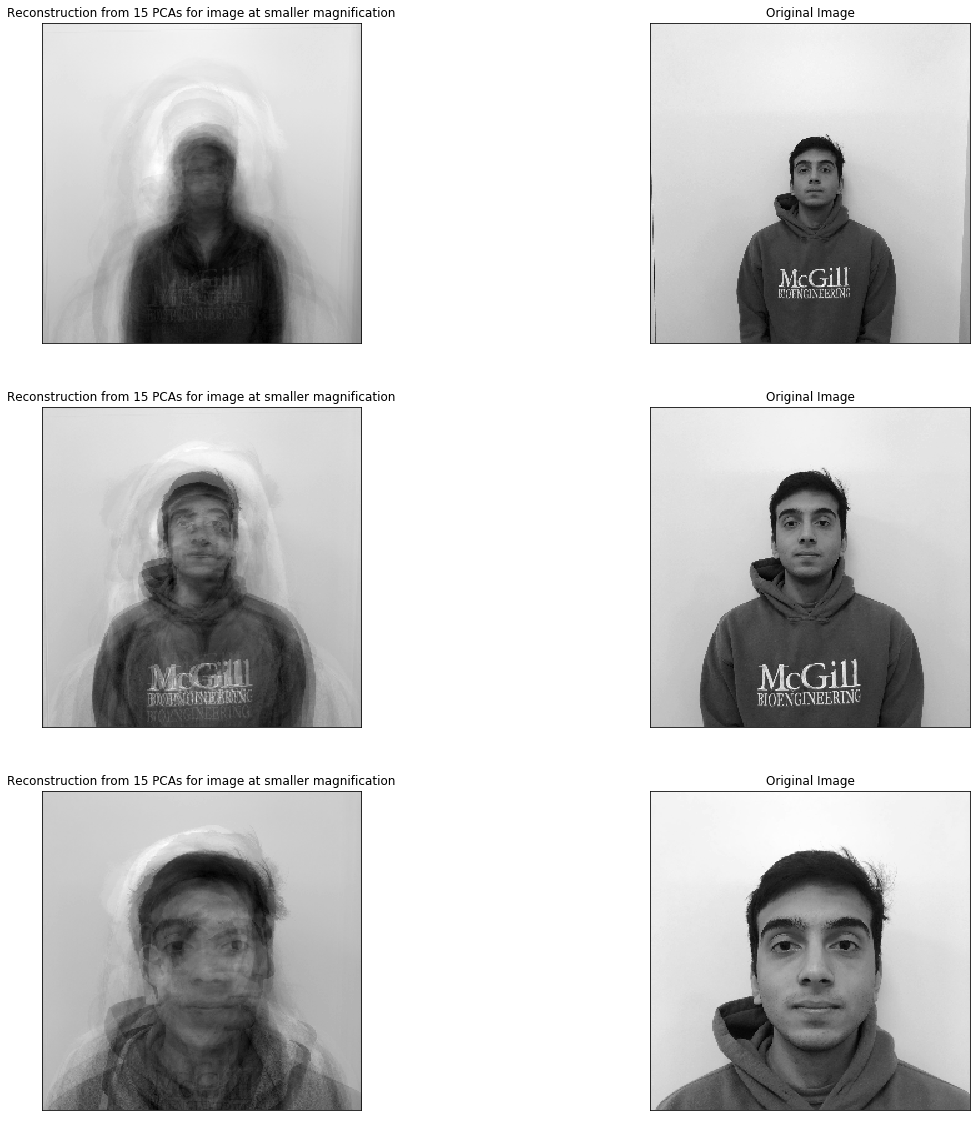

In [31]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(projections[0].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Reconstruction from 15 PCAs for image at smaller magnification')

plt.subplot(3,2,2)
plt.imshow(train[0].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Original Image')

plt.subplot(3,2,3),plt.imshow(projections[1].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Reconstruction from 15 PCAs for image at smaller magnification')

plt.subplot(3,2,4)
plt.imshow(train[1].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Original Image')

plt.subplot(3,2,5),plt.imshow(projections[2].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Reconstruction from 15 PCAs for image at smaller magnification')

plt.subplot(3,2,6)
plt.imshow(train[2].reshape(row,col),cmap='gray')
plt.xticks([]),plt.yticks([])
plt.title('Original Image')

plt.savefig('projections.png')
plt.show()


In [32]:
test_pca=pca2.transform(test)
person_pred = []
for j in range(70):
    distances = []
    for i in range(75):
        distances.append(np.linalg.norm(test_pca[j]-train_pca[i]))
    person_pred.append(person[np.argmin(distances)])

In [33]:
accuracy_score(person_test,person_pred)

0.7142857142857143

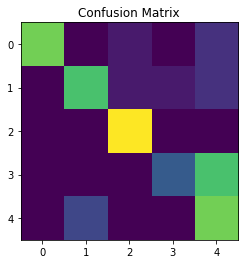

In [34]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(person_test,person_pred)

plt.figure()
plt.title('Confusion Matrix')
plt.imshow(conf)
plt.savefig('conf_matrix.png')
plt.show()

In [45]:
conf

array([[11,  0,  1,  0,  2],
       [ 0, 10,  1,  1,  2],
       [ 0,  0, 14,  0,  0],
       [ 0,  0,  0,  4, 10],
       [ 0,  3,  0,  0, 11]], dtype=int64)

#### Detection of Faces

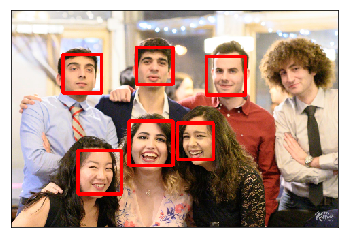

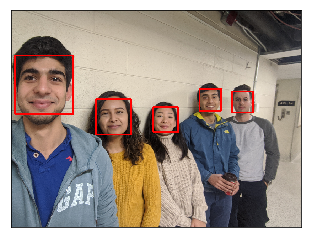

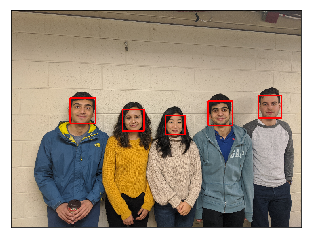

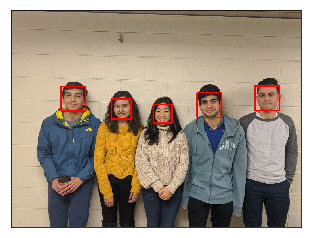

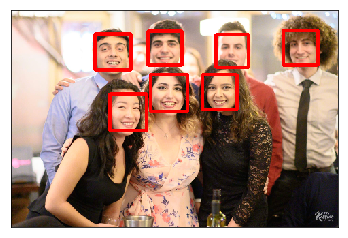

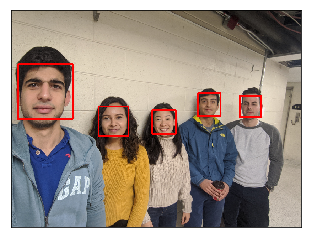

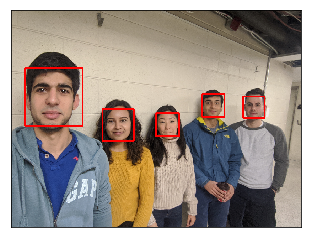

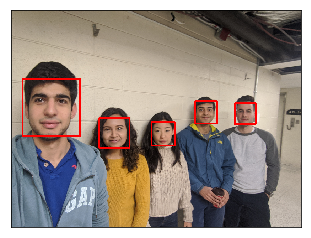

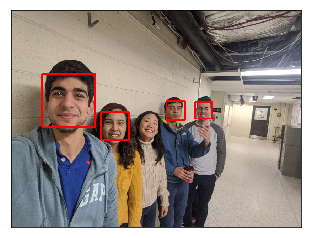

In [35]:
for image in detected:
    plt.imshow(image),plt.xticks([]),plt.yticks([])
    plt.show()
        

In [36]:
mat_gp = []
for i in range(len(all_rois)):
    flat = all_rois[i].flatten()
    mat_gp.append(flat)
test_group = np.array(mat_gp)

In [37]:
group_resized = []
for i in range(len(all_rois)):
    group_resized.append(cv2.resize(all_rois[i],(256,256)))

In [38]:
mat_gp = []
for i in range(len(all_rois)):
    flat = group_resized[i].flatten()
    mat_gp.append(flat)
test_group_resized = np.array(mat_gp)

In [39]:
t2=cv2.resize(all_rois[0],(128,128))

In [40]:
group_resized[0].shape

(256, 256)

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15).fit(train)
train_pca = pca.transform(train)

In [42]:
group_test_pca = pca.transform(test_group_resized)

In [43]:
person_pred_group = []
for j in range(len(all_rois)):
    distances = []
    for i in range(75):
        distances.append(np.linalg.norm(group_test_pca[j]-train_pca[i]))
    person_pred_group.append(person[np.argmin(distances)])

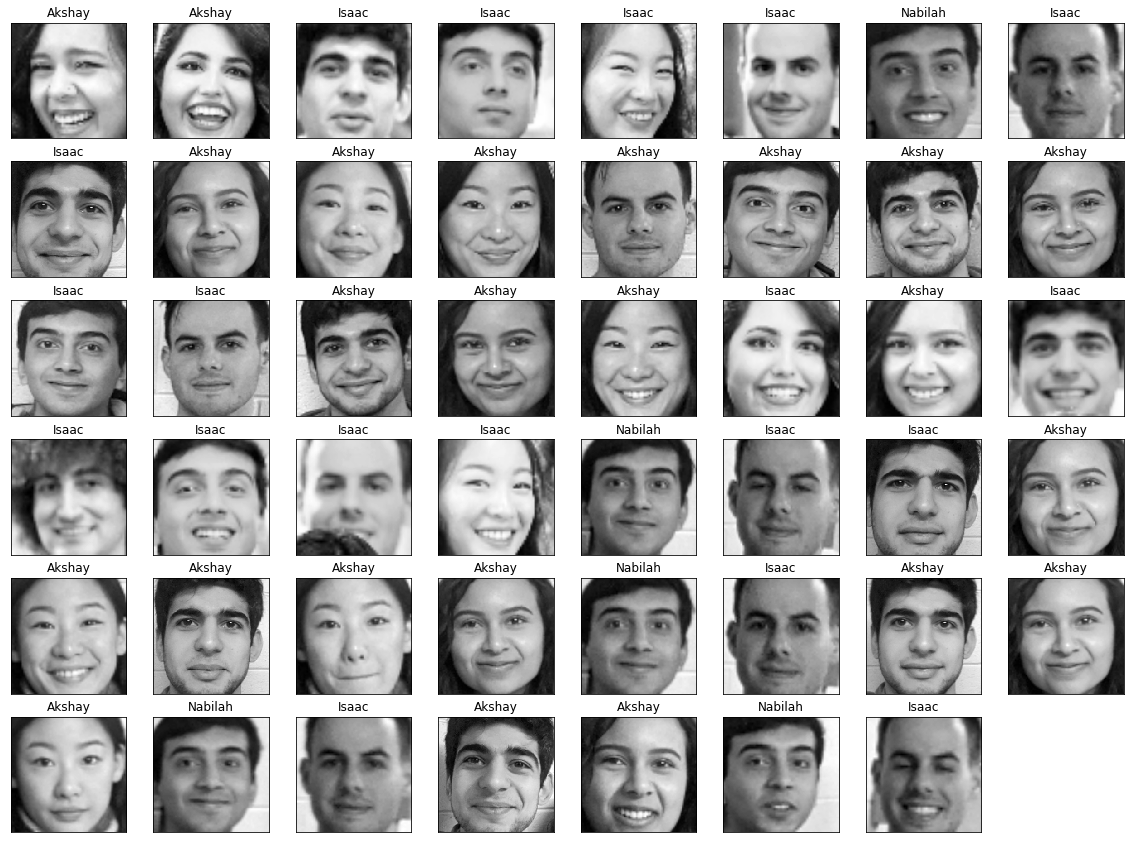

In [44]:
predicted_labels = []
plt.figure(figsize=(20,20))
for i in range(len(all_rois)):
    predicted_labels.append(person_from_label(person_pred_group[i]))
    plt.subplot(8,8,i+1),plt.imshow(group_resized[i],cmap='gray')
    plt.xticks([]),plt.yticks([]),plt.title(predicted_labels[i])
plt.savefig('predicted_images_group.png')
plt.show()